<a target="_blank" href="https://colab.research.google.com/github/alejandrogtz/cccs630-fall2023/blob/main/module03/agent-based_introduction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction to Agent-Based Simulators

## Introduction

Now that we have covered two cellular automata in the course, we will continue to increase the level of sophistication and complexity of our models and simulations.

In this module, we will add the concept of agents to our knowledge. Agents are individual entities that have specific properties, behaviours, rules, and decision-making capabilities. They interact with each other and with their environment to produce complex, often emergent, phenomena. The objective of creating this type of simulation is to study how the actions and interactions of agents lead to collective outcomes at the system level.

In preparation for the module, please review the following introductory article about agent-based models.

Please review the following introductory article about agent-based models in preparation for the module.

https://simudyne.com/resources/how-do-agent-based-models-work/

## Concepts

Below, you will find a list of important concepts we will review in the module.

- Agent-based models
- Agents
- Schelling's model
- Segregation models

## Interaction

In this interaction, we will study Schelling's segregation model. The model was created by the American economist Thomas Schelling in the 1970s.

The model has two types of agents, agent types A and B, that operate on a two-dimensional grid (similar to Conway's cellular automata). Each cell of the grid can be in one of three states:

- Occupied by an agent type 1 (red)
- Occupied by an agent type 2 (blue)
- Unoccupied or vacant, and represented by a zero on the grid (white)

Visually, assuming a 5 x 5 grid, the initial conditions would look like the following image.

<img src="https://drive.google.com/uc?export=view&id=1bGUkcSTB6Y9cCKXNt3T4-gGZ3_Q0nVTH" width="300" />

Each agent, whether type A or B, has a preference regarding the type of neighbours they want to be surrounded by. An agent wants at least a certain fraction of its neighbours to be of the same type. If this preference is not met, the agent is considered "unhappy" and will want to move. In each discrete cycle, all unhappy agents are first identified and then transferred to a vacant location randomly.

Schelling's model explains how small preferences for one's neighbours to be of the same type can lead to large-scale patterns of segregation, even when individuals do not have an intrinsic or strong preference to be separated from others.

### Instructions

- Simulate the following tolerance thresholds for the agents:
    - High tolerance, threshold < 0.2
    - Average tolerance, threshold > 0.2 and threshold < 0.7
    - Low tolerance, threshold < 0.3
- Analyze the patterns that emerge on the grid.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import animation, rc, colors

rc('animation', html='html5')

In [3]:
# Function to create a grid with randomly allocated agents
# On the grid: 0 = empty (white), 1 = agent type 1 (red), 2 = agent type 2 (blue)
def initialize_grid(grid_size, minority_ratio):    
    grid = np.random.choice([0, 1, 2], size=(grid_size, grid_size), p=[1 - minority_ratio, minority_ratio / 2, minority_ratio / 2])
    return grid

In [4]:
# Function to count the number of similar neighbors
def count_neighbors(grid, axis_0, axis_1, agent_type, radius=1):
    neighbors = grid[max(0, axis_0 - radius): min(axis_0 + radius + 1, grid.shape[0]),
                     max(0, axis_1 - radius): min(axis_1 + radius + 1, grid.shape[1])]
    return np.count_nonzero(neighbors == agent_type)

In [39]:
# Function to determine the average happiness level and the percentage of happy agents on the grid
def calculate_grid_happiness(grid_history,threshold):
    grid_happiness_level = []
    grid_happy_agents = []

    for grid in grid_history:
        
        total_agents = len(np.argwhere(grid >= 1)) # Number of agents type 1 and above
        
        agents_happiness_level = []
        count_happy_agents = 0
        for axis_0 in range(grid.shape[0]):
            for axis_1 in range(grid.shape[1]):
                if grid[axis_0, axis_1]>0: # Ignore vacant spaces
                    happiness_level = calculate_happiness(grid,axis_0,axis_1)
                    agents_happiness_level.append(happiness_level)
                    if (happiness_level>=threshold):
                        count_happy_agents += 1
                        
        grid_happiness_level.append(sum(agents_happiness_level)/len(agents_happiness_level))
        grid_happy_agents.append(count_happy_agents/total_agents)
    
    return (grid_happiness_level,grid_happy_agents)

In [40]:
# Function to determine the happiness level of a cell.
def calculate_happiness(grid, axis_0, axis_1, radius=1):
    agent_type = grid[axis_0, axis_1] # Agent type of the cell
    
    agent_types = [1 , 2]
    agent_types.remove(agent_type)
     
    different_neighbors = count_neighbors(grid, axis_0, axis_1, agent_types.pop(0), radius) # Count number neighbors of different type
    
    similar_neighbors = count_neighbors(grid, axis_0, axis_1, agent_type, radius) - 1  # Count excludes the agent itself

    total_neighbors = similar_neighbors + different_neighbors
    
    if total_neighbors == 0:
        return 0
    
    return similar_neighbors / total_neighbors

In [41]:
def identify_unhappy_agents(grid, threshold, radius=1):
    unhappy_agents = []
    for axis_0 in range(grid.shape[0]):
        for axis_1 in range(grid.shape[1]):
            if grid[axis_0, axis_1]>0:
                if (calculate_happiness(grid, axis_0, axis_1, radius)<threshold):
                    unhappy_agents.append([axis_0,axis_1])
    return(unhappy_agents)

In [42]:
def move_unhappy_agents(grid, unhappy_agents, threshold, radius=1):
    new_grid = grid.copy()
    for unhappy_agent in unhappy_agents:
        axis_0, axis_1 = unhappy_agent
        empty_spaces = np.argwhere(new_grid == 0)
        if len(empty_spaces) > 0:
            np.random.shuffle(empty_spaces)
            new_axis_0, new_axis_1 = empty_spaces[0]
            new_grid[new_axis_0, new_axis_1] = grid[axis_0, axis_1]
            new_grid[axis_0, axis_1] = 0
    return new_grid  

In [43]:
# Function to debug the code. The function shows a single grid.
def visualize_grid(grid): 
    custom_cmap = colors.LinearSegmentedColormap.from_list("", ["white","red","blue"])
    plt.imshow(grid, cmap=custom_cmap, vmin=0, vmax=2)
    plt.xticks([]) # Remove the x-axis information
    plt.yticks([]) # Remove the y-axis information
    plt.show()

In [44]:
def schelling_model(grid_size=20, minority_ratio=0.2, threshold=0.3, max_iterations=100, radius=1):
    grid = initialize_grid(grid_size, minority_ratio)
    grid_history = [grid.copy()]

    for i in range(max_iterations):
        unhappy_agents = identify_unhappy_agents(grid, threshold, radius)
        new_grid = move_unhappy_agents(grid, unhappy_agents, threshold, radius)
        
        if np.array_equal(grid, new_grid):  # Converged, no more movements needed
            break
        grid = new_grid
        grid_history.append(grid.copy())

    return grid_history

In [106]:
"""
Enter the threshold value for the agents 
"""
threshold=0.7

In [107]:
grid_history = schelling_model(grid_size=100, minority_ratio=0.7, threshold=threshold, max_iterations=30, radius=1)

In [108]:
plt.ioff() # Turn off interactive mode

fig = plt.figure(figsize=(10, 10))
    
images = []
    
custom_cmap = colors.LinearSegmentedColormap.from_list("", ["white","red","blue"])

for grid in grid_history:
    image = plt.imshow(grid, cmap=custom_cmap, vmin=0, vmax=2)
    plt.xticks([])
    plt.yticks([])
    images.append([image])
    
plt.close(fig) # Close the figure programmatically

In [109]:
ani = animation.ArtistAnimation(fig, images, interval=500, blit=True, repeat=False) # Create the animation

In [110]:
ani # Display the animation

Text(0, 0.5, 'Average Happiness Level')

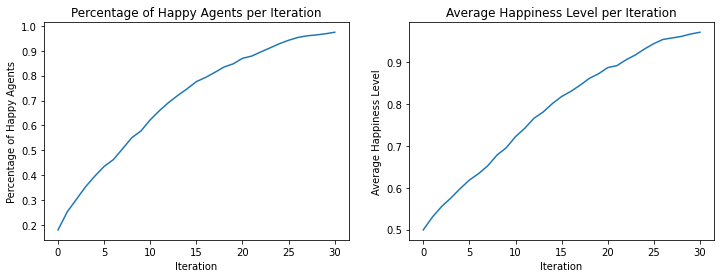

In [111]:
# Plot the happiness level and the percentage of happy agents
grid_happiness_level, grid_happy_agents = calculate_grid_happiness(grid_history, threshold)
interations = list(range(len(grid_happiness_level)))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(interations,grid_happy_agents)
axs[0].set_title('Percentage of Happy Agents per Iteration')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Percentage of Happy Agents")

axs[1].plot(interations,grid_happiness_level)
axs[1].set_title('Average Happiness Level per Iteration')
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Average Happiness Level")

## Recommended Readings

Once you have completed the interaction portion of the module, please read the following recommended reading.

- Chapter 2 - Simple Rules, Pages 46 - 45. Tranquillo, J. V. (2019). An introduction to complex systems: Making sense of a changing world. Springer. https://mcgill.on.worldcat.org/oclc/1087498746